In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"
os.environ["HADOOP_HOME"] = "/content/spark-3.4.1-bin-hadoop3" # Add Hadoop home for consistency with Spark
os.environ["PATH"] += os.pathsep + os.environ["SPARK_HOME"] + "/bin"
os.environ["PATH"] += os.pathsep + os.environ["HADOOP_HOME"] + "/bin" # Add Hadoop path
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"  # Use Python3 explicitly


In [ ]:
# Install PySpark
!pip install -q findspark

In [ ]:
# Initialize Spark
import findspark
import os
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NBA-Analysis2") \
    .master("local[*]") \
    .config("spark.driver.extraClassPath", os.environ["HADOOP_HOME"] + "/etc/hadoop/*") \
    .getOrCreate()

spark

In [ ]:
df = spark.read.csv("dataset2.csv", header=True, inferSchema=True)
print(df)

DataFrame[EVENTID: int, EVENTNUM: int, GAME_ID: int, HOMEDESCRIPTION: string, PCTIMESTRING: timestamp, PERIOD: int, PLAYER1_ID: int, PLAYER1_NAME: string, PLAYER1_TEAM_ABBREVIATION: string, PLAYER1_TEAM_CITY: string, PLAYER1_TEAM_ID: int, PLAYER1_TEAM_NICKNAME: string, PLAYER2_ID: int, PLAYER2_NAME: string, PLAYER2_TEAM_ABBREVIATION: string, PLAYER2_TEAM_CITY: string, PLAYER2_TEAM_ID: int, PLAYER2_TEAM_NICKNAME: string, PLAYER3_ID: int, PLAYER3_NAME: string, PLAYER3_TEAM_ABBREVIATION: string, PLAYER3_TEAM_CITY: string, PLAYER3_TEAM_ID: int, PLAYER3_TEAM_NICKNAME: string, SCORE: string, SCOREMARGIN: string, VISITORDESCRIPTION: string]


In [ ]:
df

DataFrame[EVENTID: int, EVENTNUM: int, GAME_ID: int, HOMEDESCRIPTION: string, PCTIMESTRING: timestamp, PERIOD: int, PLAYER1_ID: int, PLAYER1_NAME: string, PLAYER1_TEAM_ABBREVIATION: string, PLAYER1_TEAM_CITY: string, PLAYER1_TEAM_ID: int, PLAYER1_TEAM_NICKNAME: string, PLAYER2_ID: int, PLAYER2_NAME: string, PLAYER2_TEAM_ABBREVIATION: string, PLAYER2_TEAM_CITY: string, PLAYER2_TEAM_ID: int, PLAYER2_TEAM_NICKNAME: string, PLAYER3_ID: int, PLAYER3_NAME: string, PLAYER3_TEAM_ABBREVIATION: string, PLAYER3_TEAM_CITY: string, PLAYER3_TEAM_ID: int, PLAYER3_TEAM_NICKNAME: string, SCORE: string, SCOREMARGIN: string, VISITORDESCRIPTION: string]

In [ ]:
df.printSchema()
df.columns

root
 |-- EVENTID: integer (nullable = true)
 |-- EVENTNUM: integer (nullable = true)
 |-- GAME_ID: integer (nullable = true)
 |-- HOMEDESCRIPTION: string (nullable = true)
 |-- PCTIMESTRING: timestamp (nullable = true)
 |-- PERIOD: integer (nullable = true)
 |-- PLAYER1_ID: integer (nullable = true)
 |-- PLAYER1_NAME: string (nullable = true)
 |-- PLAYER1_TEAM_ABBREVIATION: string (nullable = true)
 |-- PLAYER1_TEAM_CITY: string (nullable = true)
 |-- PLAYER1_TEAM_ID: integer (nullable = true)
 |-- PLAYER1_TEAM_NICKNAME: string (nullable = true)
 |-- PLAYER2_ID: integer (nullable = true)
 |-- PLAYER2_NAME: string (nullable = true)
 |-- PLAYER2_TEAM_ABBREVIATION: string (nullable = true)
 |-- PLAYER2_TEAM_CITY: string (nullable = true)
 |-- PLAYER2_TEAM_ID: integer (nullable = true)
 |-- PLAYER2_TEAM_NICKNAME: string (nullable = true)
 |-- PLAYER3_ID: integer (nullable = true)
 |-- PLAYER3_NAME: string (nullable = true)
 |-- PLAYER3_TEAM_ABBREVIATION: string (nullable = true)
 |-- PLAY

['EVENTID',
 'EVENTNUM',
 'GAME_ID',
 'HOMEDESCRIPTION',
 'PCTIMESTRING',
 'PERIOD',
 'PLAYER1_ID',
 'PLAYER1_NAME',
 'PLAYER1_TEAM_ABBREVIATION',
 'PLAYER1_TEAM_CITY',
 'PLAYER1_TEAM_ID',
 'PLAYER1_TEAM_NICKNAME',
 'PLAYER2_ID',
 'PLAYER2_NAME',
 'PLAYER2_TEAM_ABBREVIATION',
 'PLAYER2_TEAM_CITY',
 'PLAYER2_TEAM_ID',
 'PLAYER2_TEAM_NICKNAME',
 'PLAYER3_ID',
 'PLAYER3_NAME',
 'PLAYER3_TEAM_ABBREVIATION',
 'PLAYER3_TEAM_CITY',
 'PLAYER3_TEAM_ID',
 'PLAYER3_TEAM_NICKNAME',
 'SCORE',
 'SCOREMARGIN',
 'VISITORDESCRIPTION']

In [ ]:
df.show(5)

+-------+--------+--------+--------------------+-------------------+------+----------+-------------+-------------------------+-----------------+---------------+---------------------+----------+---------------+-------------------------+-----------------+---------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+------+-----------+--------------------+
|EVENTID|EVENTNUM| GAME_ID|     HOMEDESCRIPTION|       PCTIMESTRING|PERIOD|PLAYER1_ID| PLAYER1_NAME|PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID|PLAYER1_TEAM_NICKNAME|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID|PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME| SCORE|SCOREMARGIN|  VISITORDESCRIPTION|
+-------+--------+--------+--------------------+-------------------+------+----------+-------------+------------------------

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

# Define month-to-number mapping
month_map = {
    'Jan': '1', 'Feb': '2', 'Mar': '3', 'Apr': '4',
    'May': '5', 'Jun': '6', 'Jul': '7', 'Aug': '8',
    'Sep': '9', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}

def clean_score(score):
    if not score or score.strip() == '':
        return None

    score = score.strip()

    # Already valid score format
    if re.match(r"^\d+\s*-\s*\d+$", score):
        return score

    # Handle Month-Day format (e.g., Apr-6 → 6 - 4)
    for month_abbr, num in month_map.items():
        if month_abbr in score:
            parts = score.split('-')
            if len(parts) == 2:
                if month_abbr in parts[0]:
                    return f"{parts[1].strip()} - {num}"
                elif month_abbr in parts[1]:
                    return f"{parts[0].strip()} - {num}"

    # Try to extract digits in a generic fallback
    digits = re.findall(r'\d+', score)
    if len(digits) == 2:
        return f"{digits[0]} - {digits[1]}"

    return None

# Register UDF
clean_score_udf = udf(clean_score, StringType())

# Apply the cleaning function
df_cleaned = df.withColumn("CLEANED_SCORE", clean_score_udf(df["SCORE"]))
df_cleaned.select("SCORE", "CLEANED_SCORE").distinct().show(30, truncate=False)


+--------+-------------+
|SCORE   |CLEANED_SCORE|
+--------+-------------+
|63 - 69 |63 - 69      |
|83 - 106|83 - 106     |
|26 - 29 |26 - 29      |
|38 - 39 |38 - 39      |
|77 - 90 |77 - 90      |
|40 - 42 |40 - 42      |
|96 - 90 |96 - 90      |
|58 - 50 |58 - 50      |
|54 - 74 |54 - 74      |
|76 - 83 |76 - 83      |
|68 - 103|68 - 103     |
|103 - 83|103 - 83     |
|71 - 71 |71 - 71      |
|49 - 39 |49 - 39      |
|47 - 68 |47 - 68      |
|70 - 108|70 - 108     |
|24 - 44 |24 - 44      |
|25 - 31 |25 - 31      |
|74 - 112|74 - 112     |
|86 - 97 |86 - 97      |
|67 - 88 |67 - 88      |
|71 - 67 |71 - 67      |
|Dec-19  |19 - 12      |
|52 - 59 |52 - 59      |
|22 - 23 |22 - 23      |
|40 - 45 |40 - 45      |
|30 - 39 |30 - 39      |
|113 - 96|113 - 96     |
|27 - 18 |27 - 18      |
|15-Apr  |15 - 4       |
+--------+-------------+
only showing top 30 rows



In [ ]:
df.show(5)

+-------+--------+--------+--------------------+-------------------+------+----------+-------------+-------------------------+-----------------+---------------+---------------------+----------+---------------+-------------------------+-----------------+---------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+------+-----------+--------------------+
|EVENTID|EVENTNUM| GAME_ID|     HOMEDESCRIPTION|       PCTIMESTRING|PERIOD|PLAYER1_ID| PLAYER1_NAME|PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID|PLAYER1_TEAM_NICKNAME|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID|PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME| SCORE|SCOREMARGIN|  VISITORDESCRIPTION|
+-------+--------+--------+--------------------+-------------------+------+----------+-------------+------------------------

In [ ]:
df_cleaned.show(5)

+-------+--------+--------+--------------------+-------------------+------+----------+-------------+-------------------------+-----------------+---------------+---------------------+----------+---------------+-------------------------+-----------------+---------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+------+-----------+--------------------+-------------+
|EVENTID|EVENTNUM| GAME_ID|     HOMEDESCRIPTION|       PCTIMESTRING|PERIOD|PLAYER1_ID| PLAYER1_NAME|PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID|PLAYER1_TEAM_NICKNAME|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID|PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME| SCORE|SCOREMARGIN|  VISITORDESCRIPTION|CLEANED_SCORE|
+-------+--------+--------+--------------------+-------------------+------+----------+----------

In [ ]:
from pyspark.sql.functions import col

df_cleaned = df_cleaned.withColumn("SCOREMARGIN_INT", col("SCOREMARGIN").cast("int"))

In [ ]:
from pyspark.sql.functions import split, col

# Split CLEANED_SCORE into two new columns: HOME_SCORE and VISITOR_SCORE
df_cleaned = df_cleaned.withColumn("HOME_SCORE", split(col("CLEANED_SCORE"), " - ").getItem(0).cast("int")) \
                           .withColumn("VISITOR_SCORE", split(col("CLEANED_SCORE"), " - ").getItem(1).cast("int"))


In [ ]:
df_cleaned.show(5)

+-------+--------+--------+--------------------+-------------------+------+----------+-------------+-------------------------+-----------------+---------------+---------------------+----------+---------------+-------------------------+-----------------+---------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+------+-----------+--------------------+-------------+---------------+----------+-------------+
|EVENTID|EVENTNUM| GAME_ID|     HOMEDESCRIPTION|       PCTIMESTRING|PERIOD|PLAYER1_ID| PLAYER1_NAME|PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID|PLAYER1_TEAM_NICKNAME|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID|PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME| SCORE|SCOREMARGIN|  VISITORDESCRIPTION|CLEANED_SCORE|SCOREMARGIN_INT|HOME_SCORE|VISITOR_SCORE|
+-------+-----

In [ ]:
# spark.conf.set("spark.sql.execution.pandas.convertToPythonArrow", "false")

In [ ]:
from pyspark.sql.functions import col, count, when

# Total row count
total_rows = df_cleaned.count()

# Missing value count per column
missing_data = df_cleaned.select([
    (count(when(col(c).isNull(), c)) / total_rows * 100).alias(c)
    for c in df_cleaned.columns
])

# Show missing percentage for each column
missing_data.show(truncate=False)


+-------+--------+-------+-----------------+------------+------+----------+-----------------+-------------------------+-----------------+-----------------+---------------------+----------+-----------------+-------------------------+-----------------+-----------------+---------------------+----------+-----------------+-------------------------+-----------------+-----------------+---------------------+----------------+----------------+------------------+----------------+-----------------+----------------+----------------+
|EVENTID|EVENTNUM|GAME_ID|HOMEDESCRIPTION  |PCTIMESTRING|PERIOD|PLAYER1_ID|PLAYER1_NAME     |PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID  |PLAYER1_TEAM_NICKNAME|PLAYER2_ID|PLAYER2_NAME     |PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID  |PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME     |PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID  |PLAYER3_TEAM_NICKNAME|SCORE           |SCOREMARGIN     |VISITORDESCRIPTION|CLEANED_SCORE   |S

In [ ]:
df_cleaned_filtered = df_cleaned.na.drop(subset=["CLEANED_SCORE", "HOME_SCORE", "VISITOR_SCORE", "SCOREMARGIN_INT"])

In [ ]:
from pyspark.sql.functions import col

df_cleaned_filtered = df_cleaned_filtered.withColumn("HOME_SCORE", col("HOME_SCORE").cast("int")) \
                                         .withColumn("VISITOR_SCORE", col("VISITOR_SCORE").cast("int")) \
                                         .withColumn("SCOREMARGIN_INT", col("SCOREMARGIN_INT").cast("int"))


In [ ]:
from pyspark.sql.functions import col, count, when

# Total row count
total_rows = df_cleaned_filtered.count()

# Missing value count per column
missing_data2 = df_cleaned_filtered.select([
    (count(when(col(c).isNull(), c)) / total_rows * 100).alias(c)
    for c in df_cleaned_filtered.columns
])

# Show missing percentage for each column
missing_data2.show(truncate=False)


+-------+--------+-------+-----------------+------------+------+----------+-----------------+-------------------------+-----------------+-----------------+---------------------+----------+-----------------+-------------------------+-----------------+-----------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+-----+-----------+------------------+-------------+---------------+----------+-------------+
|EVENTID|EVENTNUM|GAME_ID|HOMEDESCRIPTION  |PCTIMESTRING|PERIOD|PLAYER1_ID|PLAYER1_NAME     |PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID  |PLAYER1_TEAM_NICKNAME|PLAYER2_ID|PLAYER2_NAME     |PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID  |PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME|SCORE|SCOREMARGIN|VISITORDESCRIPTION|CLEANED_SCORE|SCOREMARGIN_INT|HOME_SCORE|VISITOR_SCORE|
+-------+--------+----

In [ ]:
from pyspark.sql.functions import col

# Drop original columns
df_prepared = df_cleaned_filtered.drop("SCORE", "SCOREMARGIN")

In [ ]:
df_prepared.show(5)

+-------+--------+--------+--------------------+-------------------+------+----------+-------------+-------------------------+-----------------+---------------+---------------------+----------+---------------+-------------------------+-----------------+---------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+--------------------+-------------+---------------+----------+-------------+
|EVENTID|EVENTNUM| GAME_ID|     HOMEDESCRIPTION|       PCTIMESTRING|PERIOD|PLAYER1_ID| PLAYER1_NAME|PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID|PLAYER1_TEAM_NICKNAME|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID|PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME|  VISITORDESCRIPTION|CLEANED_SCORE|SCOREMARGIN_INT|HOME_SCORE|VISITOR_SCORE|
+-------+--------+--------+--------------------+----

In [ ]:
# Rename new processed columns
df_prepared = df_prepared.withColumnRenamed("CLEANED_SCORE", "SCORE") \
                         .withColumnRenamed("SCOREMARGIN_INT", "SCOREMARGIN")

In [ ]:
# Show updated DataFrame schema
df_prepared.printSchema()

root
 |-- EVENTID: integer (nullable = true)
 |-- EVENTNUM: integer (nullable = true)
 |-- GAME_ID: integer (nullable = true)
 |-- HOMEDESCRIPTION: string (nullable = true)
 |-- PCTIMESTRING: timestamp (nullable = true)
 |-- PERIOD: integer (nullable = true)
 |-- PLAYER1_ID: integer (nullable = true)
 |-- PLAYER1_NAME: string (nullable = true)
 |-- PLAYER1_TEAM_ABBREVIATION: string (nullable = true)
 |-- PLAYER1_TEAM_CITY: string (nullable = true)
 |-- PLAYER1_TEAM_ID: integer (nullable = true)
 |-- PLAYER1_TEAM_NICKNAME: string (nullable = true)
 |-- PLAYER2_ID: integer (nullable = true)
 |-- PLAYER2_NAME: string (nullable = true)
 |-- PLAYER2_TEAM_ABBREVIATION: string (nullable = true)
 |-- PLAYER2_TEAM_CITY: string (nullable = true)
 |-- PLAYER2_TEAM_ID: integer (nullable = true)
 |-- PLAYER2_TEAM_NICKNAME: string (nullable = true)
 |-- PLAYER3_ID: integer (nullable = true)
 |-- PLAYER3_NAME: string (nullable = true)
 |-- PLAYER3_TEAM_ABBREVIATION: string (nullable = true)
 |-- PLAY

In [ ]:
# Show top few rows
df_prepared.show(5)

+-------+--------+--------+--------------------+-------------------+------+----------+-------------+-------------------------+-----------------+---------------+---------------------+----------+---------------+-------------------------+-----------------+---------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+--------------------+------+-----------+----------+-------------+
|EVENTID|EVENTNUM| GAME_ID|     HOMEDESCRIPTION|       PCTIMESTRING|PERIOD|PLAYER1_ID| PLAYER1_NAME|PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|PLAYER1_TEAM_ID|PLAYER1_TEAM_NICKNAME|PLAYER2_ID|   PLAYER2_NAME|PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|PLAYER2_TEAM_ID|PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME|  VISITORDESCRIPTION| SCORE|SCOREMARGIN|HOME_SCORE|VISITOR_SCORE|
+-------+--------+--------+--------------------+-------------------+------

In [ ]:
df_prepared.describe().show()

+-------+------------------+------------------+--------------------+--------------------+------------------+-----------------+------------------+-------------------------+-----------------+-------------------+---------------------+------------------+------------+-------------------------+-----------------+--------------------+---------------------+----------+------------+-------------------------+-----------------+---------------+---------------------+--------------------+-------+------------------+------------------+-----------------+
|summary|           EVENTID|          EVENTNUM|             GAME_ID|     HOMEDESCRIPTION|            PERIOD|       PLAYER1_ID|      PLAYER1_NAME|PLAYER1_TEAM_ABBREVIATION|PLAYER1_TEAM_CITY|    PLAYER1_TEAM_ID|PLAYER1_TEAM_NICKNAME|        PLAYER2_ID|PLAYER2_NAME|PLAYER2_TEAM_ABBREVIATION|PLAYER2_TEAM_CITY|     PLAYER2_TEAM_ID|PLAYER2_TEAM_NICKNAME|PLAYER3_ID|PLAYER3_NAME|PLAYER3_TEAM_ABBREVIATION|PLAYER3_TEAM_CITY|PLAYER3_TEAM_ID|PLAYER3_TEAM_NICKNAME|  

Task 3 - Performing Machine Learning model using Spark MLlib


Prepare the data for the ML Process

In [ ]:
from pyspark.sql.functions import first

# Get home team and visitor team for each Game_ID
home_team_df = df_prepared.filter(col("HOMEDESCRIPTION").isNotNull()) \
    .select("GAME_ID", col("PLAYER1_TEAM_NICKNAME").alias("Home_Team")) \
    .groupBy("GAME_ID").agg(first("Home_Team").alias("Home_Team"))

visitor_team_df = df_prepared.filter(col("VISITORDESCRIPTION").isNotNull()) \
    .select("GAME_ID", col("PLAYER1_TEAM_NICKNAME").alias("Visitor_Team")) \
    .groupBy("GAME_ID").agg(first("Visitor_Team").alias("Visitor_Team"))

# Join home and visitor teams
game_teams_df = home_team_df.join(visitor_team_df, on="GAME_ID")


In [ ]:
df_enriched = df_prepared.join(game_teams_df, on="GAME_ID", how="left")


In [ ]:
from pyspark.sql.functions import lit

# Combine descriptions and assign team type
df_desc = df_enriched.withColumn(
    "DESCRIPTION",
    when(col("HOMEDESCRIPTION").isNotNull(), col("HOMEDESCRIPTION"))
    .otherwise(col("VISITORDESCRIPTION"))
).withColumn(
    "TEAM_TYPE",
    when(col("HOMEDESCRIPTION").isNotNull(), lit("HOME"))
    .otherwise(lit("VISITOR"))
)

# Assign Team and Opponent using the lookup columns
df_team_assign = df_desc.withColumn(
    "Team",
    when(col("TEAM_TYPE") == "HOME", col("Home_Team"))
    .otherwise(col("Visitor_Team"))
).withColumn(
    "Opponent",
    when(col("TEAM_TYPE") == "HOME", col("Visitor_Team"))
    .otherwise(col("Home_Team"))
)


In [ ]:
df_points = df_team_assign.withColumn(
    "Points_Scored",
    when(col("DESCRIPTION").rlike("3PT"), lit(3))
    .when(col("DESCRIPTION").rlike("2 PTS|Layup|Jump Shot"), lit(2))
    .otherwise(lit(0))
)


In [ ]:
from pyspark.sql.functions import sum as spark_sum

df_final = df_points.groupBy("GAME_ID", "PLAYER1_NAME", "Team", "Opponent") \
    .agg(spark_sum("Points_Scored").alias("Points_Scored")) \
    .withColumnRenamed("PLAYER1_NAME", "Player_Name") \
    .withColumnRenamed("GAME_ID", "Game_ID") \
    .filter((col("Player_Name").isNotNull()) & (col("Team") != col("Opponent"))) \
    .orderBy("Game_ID", "Player_Name")

df_final.show(truncate=False)


+--------+--------------------+------+--------+-------------+
|Game_ID |Player_Name         |Team  |Opponent|Points_Scored|
+--------+--------------------+------+--------+-------------+
|20000006|Bobby Jackson       |Kings |Bulls   |11           |
|20000006|Chris Webber        |Kings |Bulls   |8            |
|20000006|Darrick Martin      |Kings |Bulls   |4            |
|20000006|Doug Christie       |Kings |Bulls   |6            |
|20000006|Elton Brand         |Bulls |Kings   |4            |
|20000006|Fred Hoiberg        |Bulls |Kings   |8            |
|20000006|Jamal Crawford      |Bulls |Kings   |3            |
|20000006|Jon Barry           |Kings |Bulls   |4            |
|20000006|Khalid El-Amin      |Bulls |Kings   |7            |
|20000006|Lawrence Funderburke|Kings |Bulls   |4            |
|20000006|Marcus Fizer        |Bulls |Kings   |16           |
|20000006|Metta World Peace   |Bulls |Kings   |2            |
|20000006|Nick Anderson       |Kings |Bulls   |3            |
|2000000

In [ ]:
# Describe all numeric columns
df_final.describe().show()


+-------+-------------------+------------------+-------+--------+-----------------+
|summary|            Game_ID|       Player_Name|   Team|Opponent|    Points_Scored|
+-------+-------------------+------------------+-------+--------+-----------------+
|  count|               3064|              3064|   3064|    3064|             3064|
|   mean|2.000062322356397E7|              null|   null|    null|7.724869451697128|
| stddev|  349.8436654077477|              null|   null|    null|5.832885061301553|
|    min|           20000006|        A.C. Green|  76ers|   76ers|                0|
|    max|           20001189|Zydrunas Ilgauskas|Wizards| Wizards|               38|
+-------+-------------------+------------------+-------+--------+-----------------+



In [ ]:
from pyspark.sql.functions import col, count, when

# Total rows
total_rows = df_final.count()

# Count nulls per column
missing_counts = df_final.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_final.columns
])

missing_counts.show(truncate=False)


+-------+-----------+----+--------+-------------+
|Game_ID|Player_Name|Team|Opponent|Points_Scored|
+-------+-----------+----+--------+-------------+
|0      |0          |0   |0       |0            |
+-------+-----------+----+--------+-------------+



In [ ]:
from pyspark.sql.functions import round

# Create percentage table
missing_percentage = df_final.select([
    round((count(when(col(c).isNull(), c)) / total_rows) * 100, 2).alias(c + "_missing_%")
    for c in df_final.columns
])

missing_percentage.show(truncate=False)


+-----------------+---------------------+--------------+------------------+-----------------------+
|Game_ID_missing_%|Player_Name_missing_%|Team_missing_%|Opponent_missing_%|Points_Scored_missing_%|
+-----------------+---------------------+--------------+------------------+-----------------------+
|0.0              |0.0                  |0.0           |0.0               |0.0                    |
+-----------------+---------------------+--------------+------------------+-----------------------+



In [ ]:
model_data = df_final.select(
    F.col("Player_Name").alias("Player"),
    F.col("Opponent"),
    F.col("Points_Scored").alias("Actual_Score")
)

In [ ]:
from pyspark.ml.feature import StringIndexer

player_indexer = StringIndexer(inputCol="Player", outputCol="Player_Index")
opponent_indexer = StringIndexer(inputCol="Opponent", outputCol="Opponent_Index")

In [ ]:
indexed_data = player_indexer.fit(model_data).transform(model_data)
indexed_data = opponent_indexer.fit(indexed_data).transform(indexed_data)

In [ ]:
from pyspark.ml.feature import OneHotEncoder

# OneHotEncoder for Player and Opponent
player_encoder = OneHotEncoder(inputCol="Player_Index", outputCol="Player_OneHot")
opponent_encoder = OneHotEncoder(inputCol="Opponent_Index", outputCol="Opponent_OneHot")

encoded_data = player_encoder.fit(indexed_data).transform(indexed_data)
encoded_data = opponent_encoder.fit(encoded_data).transform(encoded_data)

Assemble the Features

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Player_OneHot", "Opponent_OneHot"],
    outputCol="features"
)

data_features = assembler.transform(encoded_data)

Split the Data

In [ ]:
train_data, test_data = data_features.randomSplit([0.8, 0.2], seed=42)

**Candidate Models**

1. Multiple Linear Regression (MLR)
- Simple, interpretable. Predicts scores using features like field goals, assists, etc.
- High accuracy (R² > 0.98) shown in NBA prediction studies.
*Ghaderyan & Hasanpour (2023) Scitepress*

2. Random Forest Regression
Captures non-linear relationships, handles complex interactions.
Comparable to MLR, good accuracy and generalization.
*Ghaderyan & Hasanpour (2023) Scitepress*

3. Gradient Boosted Trees (GBT)
Higher accuracy in complex, structured datasets.
Proven performance in ensemble-based sports analytics.
*Zhang et al. (2023) IEEE Xplore (general sports analytics use)*

In [ ]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize models
models = {
    "Linear Regression": LinearRegression(featuresCol="features", labelCol="Actual_Score"),
    "Random Forest": RandomForestRegressor(featuresCol="features", labelCol="Actual_Score"),
    "Gradient Boosted Trees": GBTRegressor(featuresCol="features", labelCol="Actual_Score")
}

# Initialize evaluators
evaluator_r2 = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="mae")
evaluator_rmse = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="rmse")

# Train and evaluate
for name, model in models.items():
    print(f"\nTraining: {name}")
    model_fit = model.fit(train_data)
    predictions = model_fit.transform(test_data)

    r2 = evaluator_r2.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    rmse = evaluator_rmse.evaluate(predictions)

    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")



Training: Linear Regression
R² Score: 0.4016
MAE: 3.2856
RMSE: 4.2438

Training: Random Forest
R² Score: 0.0925
MAE: 4.2380
RMSE: 5.2261

Training: Gradient Boosted Trees
R² Score: 0.2261
MAE: 3.9216
RMSE: 4.8261


Best Overall: Linear Regression
Has the highest R², meaning it explains the most variance in the target

Also has the lowest MAE and lowest RMSE, meaning better accuracy and fewer big errors

Hyperparamter Tuning

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# Define model
lr = LinearRegression(featuresCol="features", labelCol="Actual_Score")

# Param grid for tuning
param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.01, 0.1])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# Evaluator
evaluator_r2 = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="r2")

# Train-validation split (faster than k-fold CV)
tvs = TrainValidationSplit(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_r2,
    trainRatio=0.8,
    parallelism=2
)

# Train best model
tuned_model = tvs.fit(train_data)
predictions = tuned_model.transform(test_data)


In [ ]:
evaluator_mae = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="mae")
evaluator_rmse = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="rmse")

r2 = evaluator_r2.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print(f"Tuned Linear Regression Results:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Tuned Linear Regression Results:
R² Score: 0.4180
MAE: 3.2567
RMSE: 4.1852


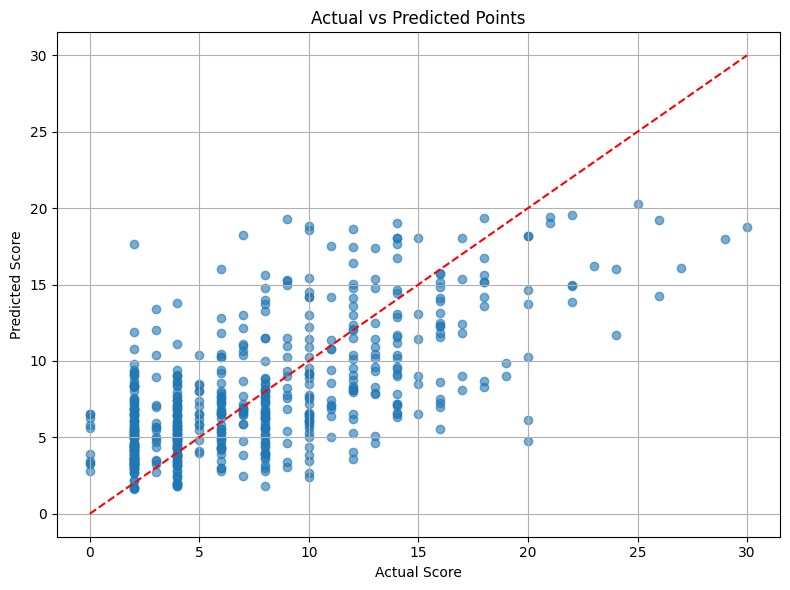

In [ ]:
# Convert predictions to pandas for visualization
pred_df = predictions.select("prediction", "Actual_Score").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pred_df["Actual_Score"], pred_df["prediction"], alpha=0.6)
plt.plot([pred_df["Actual_Score"].min(), pred_df["Actual_Score"].max()],
         [pred_df["Actual_Score"].min(), pred_df["Actual_Score"].max()], color='red', linestyle='--')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Points")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_lr_model = tuned_model.bestModel
print(f"Intercept: {best_lr_model.intercept}")
print("Coefficients:")
for coef, name in zip(best_lr_model.coefficients, best_lr_model.summary.featuresCol):
    print(f"{name}: {coef}")

Intercept: 6.535641696290342
Coefficients:
f: 0.0
e: -2.891793183430972
a: 5.178140129250916
t: 11.533668616510354
u: 1.6513118802017825
r: 7.16832306819382
e: -0.0011762256955114734
s: 2.1196403551151373


Prediction in the testing Dataset

In [ ]:
predictions = tuned_model.transform(test_data)

Evaluate the Testing Perfomence

In [ ]:
# Evaluation
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_r2 = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="mae")
evaluator_rmse = RegressionEvaluator(labelCol="Actual_Score", predictionCol="prediction", metricName="rmse")

r2 = evaluator_r2.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print(f"Final Evaluation on Test Set")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Final Evaluation on Test Set
R² Score: 0.4180
MAE: 3.2567
RMSE: 4.1852


<ipython-input-91-721d5e0077b2>:14: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


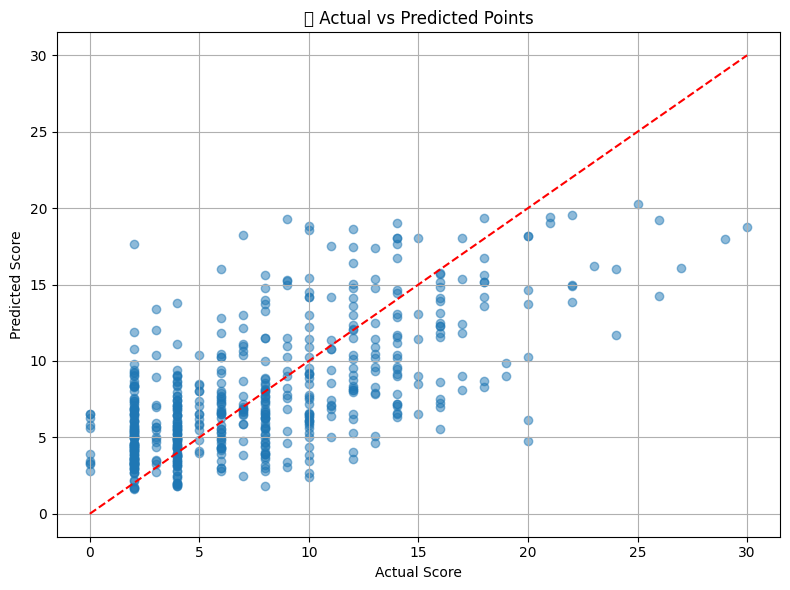

In [ ]:
# Plot predictions
pred_df = predictions.select("prediction", "Actual_Score").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pred_df["Actual_Score"], pred_df["prediction"], alpha=0.5)
plt.plot([pred_df["Actual_Score"].min(), pred_df["Actual_Score"].max()],
         [pred_df["Actual_Score"].min(), pred_df["Actual_Score"].max()], color='red', linestyle='--')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Points")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Select and show actual vs predicted values
predictions.select("Actual_Score", "prediction").show(20, truncate=False)

+------------+------------------+
|Actual_Score|prediction        |
+------------+------------------+
|4           |4.829449330512013 |
|4           |4.38748662021723  |
|20          |4.753721804949801 |
|9           |8.227133218191303 |
|11          |7.451209832872119 |
|10          |5.954291712157687 |
|8           |5.556763951703987 |
|2           |2.9270710959295942|
|2           |4.661949914401156 |
|2           |4.939736288518774 |
|2           |4.161406652986731 |
|4           |5.453895161571916 |
|4           |2.0389151247690647|
|2           |5.578290973409462 |
|6           |5.5360902044278815|
|8           |7.682016314213861 |
|16          |14.111942725416618|
|20          |18.176062468534337|
|8           |8.801940824041322 |
|6           |9.40644291210193  |
+------------+------------------+
only showing top 20 rows

